#  🤗 Transformers Finetuning

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* https://huggingface.co/docs/transformers/training
* https://huggingface.co/docs/datasets/main/en/repository_structure
* https://huggingface.co/docs/datasets/main/en/package_reference/loading_methods#datasets.load_dataset
* https://huggingface.co/docs/transformers/v4.35.2/en/training#prepare-a-dataset
* https://huggingface.co/docs/datasets/v2.0.0/en/image_process
* https://huggingface.co/docs/datasets/v3.0.1/en/package_reference/main_classes#datasets.Dataset.train_test_split
* https://huggingface.co/docs/datasets/process
* https://huggingface.co/docs/evaluate/index
* https://huggingface.co/docs/transformers/main_classes/trainer
* https://huggingface.co/docs/transformers/v4.35.2/en/main_classes/trainer#transformers.TrainingArguments
* https://albumentations.ai/docs/getting_started/image_augmentation/
* https://wandb.ai/ayush-thakur/huggingface/reports/Examples-of-Early-Stopping-in-HuggingFace-Transformers--Vmlldzo0MzE2MTM
* https://colab.research.google.com/github/wandb/examples/blob/master/colabs/huggingface/Optimize_Hugging_Face_models_with_Weights_&_Biases.ipynb#scrollTo=8k0XaprCT51P

## Задачи для совместного разбора

1\. Обсудите основные шаги по дообучению моделей из экосистемы 🤗 Transformers.

## Задачи для самостоятельного решения

In [1]:
import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from datasets import load_dataset
from torch.utils.data import DataLoader
import os
import pytorch_lightning as pl
import torchmetrics
from torch.optim import AdamW
from transformers import AutoModelForImageClassification
import sys
import subprocess
import time
import mlflow
from IPython.display import Image, display
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback, AutoModelForImageClassification
from sklearn.metrics import f1_score

c:\Projects\FU\.venv\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '1.4.18'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


<p class="task" id="1"></p>

1\. Создайте набор данных для обучения модели классификации пород кошек, используя пакет 🤗 Datasets. Разделите датасет на обучающее и тестовое множество в соотношении 80/20. 

К обучающему множеству примените следующие преобразования из пакета `albumentations`:
- Resize до 256х256;
- CenterCrop до размера 224х224;
- минимум одно преобразование, случайным образом изменяющее изображение.

К тестовому множеству примените аналогичное преобразование, но без добавления случайных изменений.

Создайте два `DataLoader` на основе обучающего и валидационного множества. Получите батч из обучающего множества и форму признаков и меток на экран. Признаки в батче должны быть уложены в четырехмерный тензор.



- [x] Проверено на семинаре

In [2]:
dataset_path = "cat_breeds_4" 

raw_dataset = load_dataset("imagefolder", data_dir=dataset_path, drop_labels=False)
if "train" in raw_dataset:
    split_dataset = raw_dataset["train"].train_test_split(
        test_size=0.2, 
        seed=42, 
        stratify_by_column="label" 
    )
else:
    split_dataset = raw_dataset

train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

labels_names = train_dataset.features["label"].names
print(f"Классы: {labels_names}")
print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

Resolving data files:   0%|          | 0/4000 [00:00<?, ?it/s]

Классы: ['American Shorthair', 'Persian', 'Russian Blue', 'Tiger']
Train: 3200, Test: 800


In [3]:
mean = (0.5000, 0.4514, 0.4066)
std = (0.2324, 0.2273, 0.2228)

train_transforms = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.OneOf([
        A.HorizontalFlip(p=1.0),
        A.Rotate(limit=20, p=1.0),
        A.GaussNoise(p=1.0) # Немного шума
    ], p=0.5),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

def transforms_transform(examples, transform_pipeline):
    images = [np.array(img.convert("RGB")) for img in examples["image"]]
    transformed_images = [transform_pipeline(image=img)["image"] for img in images]
    
    return {"pixel_values": transformed_images, "label": examples["label"]}

train_dataset.set_transform(lambda x: transforms_transform(x, train_transforms))
test_dataset.set_transform(lambda x: transforms_transform(x, val_transforms))


In [4]:
def collate_fn(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = torch.tensor([item["label"] for item in batch])
    return {"pixel_values": pixel_values, "labels": labels}

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

try:
    batch = next(iter(train_loader))
    print(f"Размер батча (Images): {batch['pixel_values'].shape}")
    print(f"Размер меток (Labels): {batch['labels'].shape}")    
    print(f"Пример метки: {batch['labels'][0]} -> {labels_names[batch['labels'][0]]}")
except Exception as e:
    print(f"{e}")

Размер батча (Images): torch.Size([32, 3, 224, 224])
Размер меток (Labels): torch.Size([32])
Пример метки: 2 -> Russian Blue


<p class="task" id="2"></p>

2\. Создайте модель при помощи класса `AutoModelForImageClassification`, заменив голову модели в соответствии с решаемой задачей  классификации. Используя стандартный цикл обучения `torch` (или `pytorch_lightning`), настройте модель. Во время обучения выводите на экран значение функции потерь и значение F1 на обучающем множестве, а также F1 на валидационном множестве. 

- [ ] Проверено на семинаре

In [5]:
class CatBreedClassifier(pl.LightningModule):
    def __init__(self, num_classes: int, id2label: dict, label2id: dict, learning_rate: float = 5e-5):
        super().__init__()
        self.save_hyperparameters()
        self.lr = learning_rate


        self.model = AutoModelForImageClassification.from_pretrained(
            "google/vit-base-patch16-224",
            num_labels=num_classes,
            id2label=id2label,
            label2id=label2id,
            ignore_mismatched_sizes=True
        )

        self.train_f1 = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='weighted')
        self.val_f1 = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='weighted')

    def forward(self, pixel_values, labels=None):
        outputs = self.model(pixel_values=pixel_values, labels=labels)
        return outputs

    def training_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']

        outputs = self(pixel_values, labels)
        loss = outputs.loss
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1)
        self.train_f1(preds, labels)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_f1", self.train_f1, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']

        outputs = self(pixel_values, labels)
        loss = outputs.loss
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1)
        self.val_f1(preds, labels)

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_f1", self.val_f1, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=self.lr)

In [6]:
lightning_model = CatBreedClassifier(
    num_classes=len(labels_names),
    id2label={i: name for i, name in enumerate(labels_names)},
    label2id={name: i for i, name in enumerate(labels_names)}
)


trainer = pl.Trainer(
    max_epochs=3,
    accelerator="auto", 
    log_every_n_steps=1
)

trainer.fit(model=lightning_model, train_dataloaders=train_loader, val_dataloaders=test_loader)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Projects\FU\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorbo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Projects\FU\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Projects\FU\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Projects\FU\.venv\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:527: Found 214 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


<p class="task" id="3"></p>

3\. Создайте модель при помощи класса `AutoModelForImageClassification`, заменив голову модели в соответствии решаемой задачей  классификации. Используя `transformers.Trainer`, настройте модель для решения задачи. Во время обучения выводите на экран значение функции потерь на обучающем и валидационном множества, а также F1 на валидационном множестве. 

Настройте `Trainer` таким образом, чтобы логирование процесса обучения осуществлялось при помощи `wandb`. Прикрепите скриншоты интерфейса `wandb` с результатами. 

- [ ] Проверено на семинаре


In [22]:
def run_screenshot_script(url, output_path, width=1920, height=1480, sleep=5):
    """Запускает Playwright в подпроцессе для снятия скриншота."""
    script_code = """
import sys
import time
from playwright.sync_api import sync_playwright

def take_screenshot(url, output_path, width, height, sleep):
    try:
        with sync_playwright() as p:
            browser = p.chromium.launch()
            page = browser.new_page()
            page.set_viewport_size({"width": int(width), "height": int(height)})
            page.goto(url)
            time.sleep(int(sleep)) 
            page.screenshot(path=output_path, full_page=True)
            browser.close()
        print(f"Picture saved: {output_path}")
    except Exception as e:
        print(f"Error: {e}", file=sys.stderr)
        sys.exit(1)

if __name__ == "__main__":
    take_screenshot(sys.argv[1], sys.argv[2], sys.argv[3], sys.argv[4], sys.argv[5])
"""
    try:
        subprocess.run(
            [sys.executable, "-c", script_code, url, output_path, str(width), str(height), str(sleep)],
            capture_output=True, text=True, check=True
        )
        print(f"📸 Скриншот сохранен: {output_path}")
    except subprocess.CalledProcessError as e:
        print(f"❌ Ошибка скриншота:\n{e.stderr}", file=sys.stderr)



if 'mlflow_process' in locals() and mlflow_process.poll() is None:
    mlflow_process.terminate()
    mlflow_process.wait()

port = 5000
mlflow_tracking_uri = "file:./mlruns"
experiment_name = "Cat_Breeds_HF_Trainer"

mlflow_process = subprocess.Popen(
    ["mlflow", "ui", "--port", str(port), "--backend-store-uri", mlflow_tracking_uri],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL
)
print(f"🚀 MLflow UI запущен на http://localhost:{port}")
print(f"PID: {mlflow_process.pid}")

# Настраиваем клиент
mlflow.set_tracking_uri(mlflow_tracking_uri)
mlflow.set_experiment(experiment_name)

🚀 MLflow UI запущен на http://localhost:5000
PID: 32076


<Experiment: artifact_location='file:c:/Projects/FU/Course_3/DL/mlruns/912904322811962814', creation_time=1764174059078, experiment_id='912904322811962814', last_update_time=1764174059078, lifecycle_stage='active', name='Cat_Breeds_HF_Trainer', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [ ]:
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=len(labels_names),
    id2label={i: l for i, l in enumerate(labels_names)},
    label2id={l: i for i, l in enumerate(labels_names)},
    ignore_mismatched_sizes=True
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    f1 = f1_score(labels, predictions, average='weighted')
    return {"f1": f1}

LOGGING_STEPS = 10
EVAL_STEPS = 50 

early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.01
)


training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10, 
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_ratio=0.1,
    logging_strategy="steps",
    logging_steps=LOGGING_STEPS,
    eval_strategy="steps",
    eval_steps=EVAL_STEPS,
    save_strategy="steps",
    save_steps=EVAL_STEPS,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to=["mlflow"],
    remove_unused_columns=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

trainer.train()



eval_results = trainer.evaluate()
print(f"{eval_results}")

run_id = mlflow.active_run().info.run_id
mlflow.end_run()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1
50,1.341900,1.301800,0.380563
100,1.091100,0.951108,0.676424
150,0.759500,0.641063,0.780135
200,0.677700,0.506068,0.796766
250,0.541400,0.475592,0.809110
300,0.624100,0.433730,0.804355
350,0.584800,0.466938,0.816436
400,0.691500,0.517887,0.785585


{'eval_loss': 0.4669376313686371, 'eval_f1': 0.8164360986370628, 'eval_runtime': 6.2389, 'eval_samples_per_second': 128.227, 'eval_steps_per_second': 16.028, 'epoch': 1.0}


📸 Скриншот сохранен: images/run_metrics_10aa6f09f7684244849f34073b894e23.png


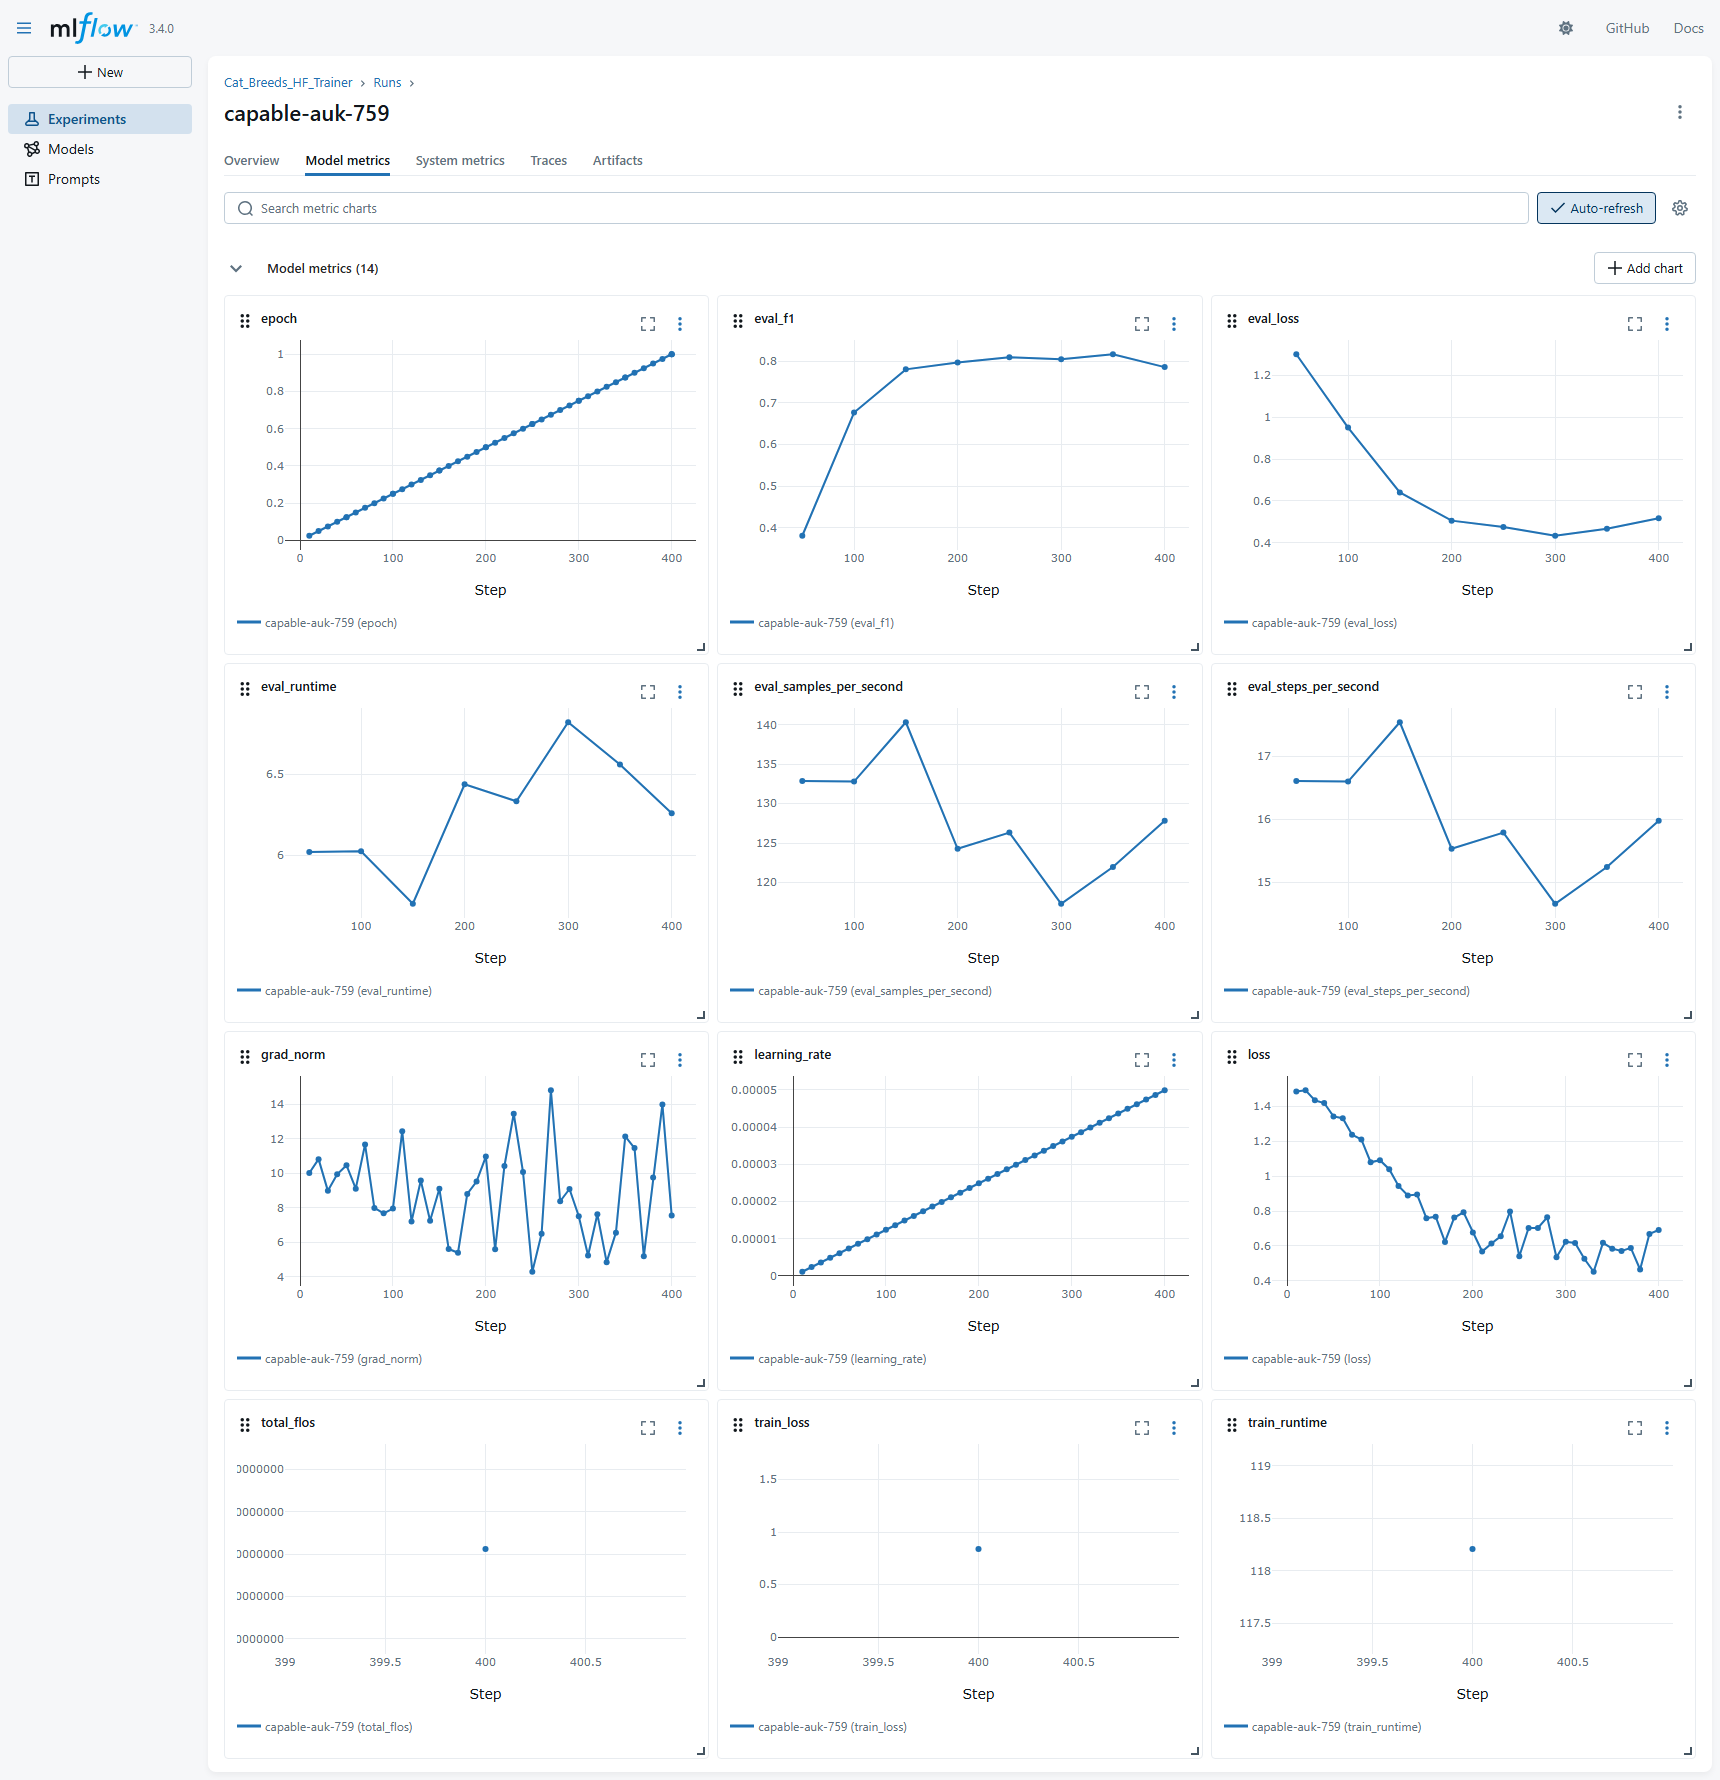

In [45]:

runs = mlflow.search_runs(experiment_ids=[mlflow.get_experiment_by_name(experiment_name).experiment_id])
id = mlflow.search_runs(experiment_ids=[mlflow.get_experiment_by_name(experiment_name).experiment_id]).dropna().index[0]
run_id = runs.iloc[id].run_id
experiment_id = runs.iloc[id].experiment_id


run_url = f"http://localhost:{port}/#/experiments/{experiment_id}/runs/{run_id}"

os.makedirs("images", exist_ok=True)
screenshot_path = f"images/run_metrics_{run_id}.png"

try:
    target_url = run_url + "/model-metrics" 
    run_screenshot_script(target_url, screenshot_path, 1720, 1780, 5)
    
    display(Image(filename=screenshot_path))
except Exception as e:
    print(f"Could not display screenshot: {e}")

<p class="task" id="4"></p>

4\. Повторите решение задачи 3, настроив процедуру ранней остановки (используйте механизм callback для Trainer). Логика ранней остановки следующая: если метрика F1 не увеличивалась на валидационном множестве в течение 3 последних эпох, то процесс обучения останавливается.

- [ ] Проверено на семинаре


См ЗАДАЧА 3 $\Uparrow$ []()